In [1]:
import numpy as np
import pandas as pd
import pickle
import sys
sys.setrecursionlimit(5000)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

**Collect the data from the webscraping notebook**
---


In [2]:
fname='8000new_films.pickle'
with open(fname, 'rb') as to_read:
    film_dictionary = pickle.load(to_read)
to_read.close()
movies_df = pd.DataFrame(film_dictionary).transpose()

In [3]:
#import inflation data
cpi_df = pd.read_csv('cpi.csv', names=['year','cpi'])

**Begin Cleaning
---

In [4]:
movies_df.fillna(value=0,inplace=True)
movies_df.drop(movies_df[movies_df['Release Date'] == 0].index, inplace=True)
movies_df['year'] = movies_df['Release Date'].dt.year

In [5]:
movies_df = movies_df.merge(cpi_df, how='left')

In [6]:
movies_df['inflation_domestic']=movies_df['Domestic']*movies_df['cpi']

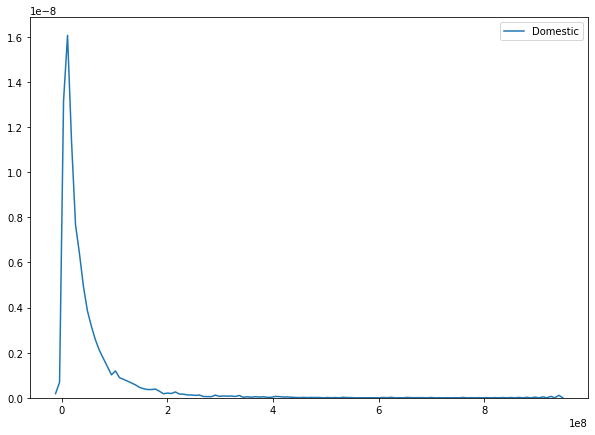

In [268]:
fig = plt.gcf()
fig.set_size_inches(10, 7)
sns.kdeplot(movies_df['Domestic'])

In [8]:
def logger(x):
    try:
        return np.log10(x)
    except:
        return np.nan
movies_df['log_domestic'] = movies_df['inflation_domestic'].apply(logger)

Text(0.5, 1.0, 'Distributions Before and After Log')

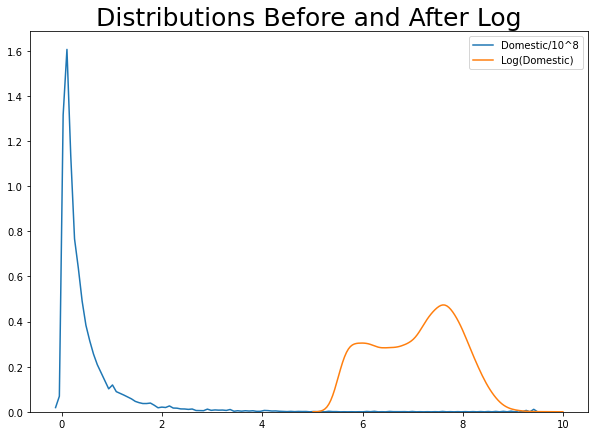

In [273]:
fig = plt.gcf()
fig.set_size_inches(10, 7)
sns.kdeplot(movies_df['Domestic']/100000000,label='Domestic/10^8')
sns.kdeplot(movies_df['log_domestic'],label='Log(Domestic)')
plt.title("Distributions Before and After Log",fontsize=25)

**Feature Engineering
---
*What can I do with all these actors?

In [10]:
def build_experience_column(df,columns):
    """
    Tracks total counts per person per production role over time,
    and builds a column of the highest experience of any person in a particular production role per movie.
    """
    df.sort_values(by='Release Date', inplace=True)
    name_dict = {}
    experience = {}
    highest = 0
    for row in df.index:
        highest = 0
        for name in df.loc[row,columns]:
            if name == 0: continue
            elif name not in name_dict.keys():
                name_dict[name] = 0
            highest=max(name_dict[name],highest)
            name_dict[name] += 1
        experience[row] = highest
    return pd.Series(experience)

In [11]:
def length_corrector(wrong_length):
    """
    Corrects for somehow being off by a factor of 60
    """
    if wrong_length > 600:
        return wrong_length/60
    else:
        return wrong_length

movies_df.Length = movies_df.Length.apply(length_corrector)

In [12]:
movies_df['actor_experience']=build_experience_column(movies_df,['actor_1','actor_2','actor_3','actor_4'])
movies_df['director_experience']=build_experience_column(movies_df,['Director_1','Director_2'])
movies_df['producer_experience']=build_experience_column(movies_df,['Producer_1','Producer_2'])
movies_df['editor_experience']=build_experience_column(movies_df,['Editor_1','Editor_2'])
movies_df['cinematographer_experience']=build_experience_column(movies_df,['Cinematographer_1','Cinematographer_2'])
movies_df['writer_experience']=build_experience_column(movies_df,['Writer_1','Writer_2'])
movies_df['production_designer_experience']=build_experience_column(movies_df,['Production Designer_1','Production Designer_2'])
movies_df['composer_experience']=build_experience_column(movies_df,['Composer_1','Composer_2'])

*Are there interactions between commonly combined genres?

In [13]:
movies_df['HorrorComedy']=movies_df['Comedy']*movies_df['Horror']
movies_df['Dramedy']=movies_df['Comedy']*movies_df['Drama']
movies_df['FamilyAnimation']=movies_df['Family']*movies_df['Animation']
movies_df['CrimeComedy']=movies_df['Comedy']*movies_df['Crime']
movies_df['CrimeDrama']=movies_df['Drama']*movies_df['Crime']
movies_df['HistoricalDrama']=movies_df['Drama']*movies_df['History']
movies_df['RomCom']=movies_df['Comedy']*movies_df['Romance']

Dropping some columns to form a cleaner frame

In [14]:
cleaned_movies = pd.DataFrame(movies_df[movies_df['year'] > 1980][['Domestic','Domestic Distributor', 'MPAA', 'Length',
       'Action', 'Adventure', 'Animation', 'Comedy', 'Family', 'Sci-Fi',
       'Drama', 'Musical', 'Fantasy',
       'Romance', 'Crime', 'Mystery', 'Thriller', 'Sport', 'Music', 'History', 'War', 'Biography',
       'Horror', 'Western', 'Documentary', 'Short', 'News', 'year', 'log_domestic', 'actor_experience',
       'director_experience', 'producer_experience', 'editor_experience',
       'cinematographer_experience', 'writer_experience',
       'production_designer_experience', 'composer_experience', 'HorrorComedy',
       'Dramedy', 'FamilyAnimation', 'CrimeComedy', 'CrimeDrama',
       'HistoricalDrama', 'RomCom']])

Text(0.5, 1.0, 'Raw vs Adjusted Domestic Gross')

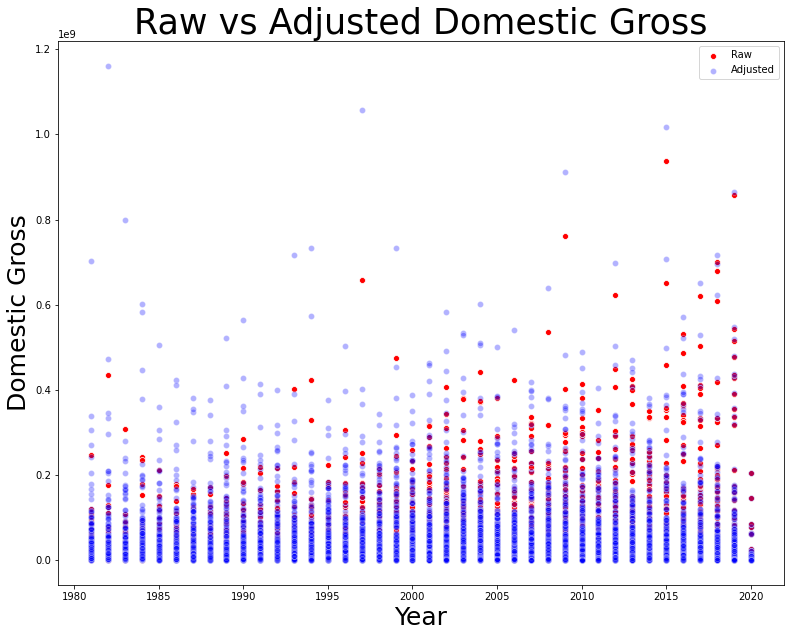

In [303]:
fig = plt.gcf()
fig.set_size_inches(13, 10)
sns.scatterplot(x='year', y='Domestic', data=movies_df[movies_df['year'] > 1980],
                alpha=1, color='red',label='Raw')
sns.scatterplot(x='year', y='inflation_domestic', data=movies_df[movies_df['year'] > 1980],
                alpha=.3, color='blue',label='Adjusted')

plt.xlabel("Year",fontsize=25)
plt.ylabel('Domestic Gross',fontsize=25)
plt.title("Raw vs Adjusted Domestic Gross",fontsize=35)

*Final Engineering touches

In [344]:
cleaned_movies['G'] = pd.get_dummies(cleaned_movies['MPAA'])['G']
cleaned_movies['PG'] = pd.get_dummies(cleaned_movies['MPAA'])['PG']
cleaned_movies['PG-13'] = pd.get_dummies(cleaned_movies['MPAA'])['PG-13']
cleaned_movies['R'] = pd.get_dummies(cleaned_movies['MPAA'])['R']
cleaned_movies['TV-14'] = pd.get_dummies(cleaned_movies['MPAA'])['TV-14']

In [215]:
cleaned_movies['log_actor']=np.log10(cleaned_movies['actor_experience']+1)
cleaned_movies['log_director']=np.log10(cleaned_movies['director_experience']+1)
cleaned_movies['log_editor']=np.log10(cleaned_movies['editor_experience']+1)
cleaned_movies['log_writer']=np.log10(cleaned_movies['writer_experience']+1)
cleaned_movies['log_cinematographer']=np.log10(cleaned_movies['cinematographer_experience']+1)
cleaned_movies['log_producer']=np.log10(cleaned_movies['producer_experience']+1)
cleaned_movies['log_production_designer']=np.log10(cleaned_movies['production_designer_experience']+1)
cleaned_movies['log_composer']=np.log10(cleaned_movies['composer_experience']+1)

**Modeling
---

In [345]:
#Separate our features from our target

X = cleaned_movies.copy()

y = cleaned_movies['log_domestic']

In [346]:
#Split the data 80 - 20 train-val/test

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=43)

In [353]:
selected_columns=['log_composer',
                  'log_editor',
                  'log_production_designer',
                  'log_producer',
                  'log_cinematographer',
                  'log_actor',
                  'log_director',
                  'log_writer',
                  'Length',
                  'Drama',
                  'PG-13']

*Ridge Regression with randomly generated K-folds

In [310]:

def RMS_error(y_true, y_pred):
    return np.mean((y_pred - y_true)**2) 

In [348]:
alphalist = 10**(np.linspace(-5,10,100))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for seed in range (2,12,1):
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=seed)
    for i,curr_alpha in enumerate(alphalist):
        steps = [('standardize', StandardScaler()), 
                 ('lasso', Ridge(alpha = curr_alpha))]

        pipe = Pipeline(steps)
        pipe.fit(X_train.loc[:,selected_columns].values, y_train)
        val_set_pred = pipe.predict(X_val.loc[:,selected_columns].values)
        err_vec_val[i] = err_vec_val[i]+RMS_error(y_val, val_set_pred)

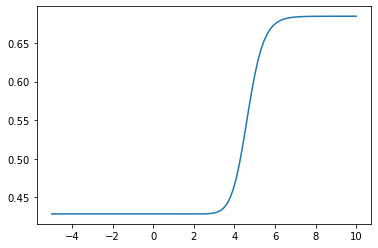

In [220]:
plt.plot(np.log10(alphalist), err_vec_val/10)

In [362]:
ridged=Ridge(alpha=10**2.5)
ridged.fit(X_train_val[selected_columns],y_train_val)

print(ridged.intercept_)
ridge_betas = pd.DataFrame(zip(selected_columns, ridged.coef_)).sort_values(by=1).set_index(0)
print(ridge_betas)
ridge_betas.drop(['Drama','Length','PG-13'], inplace=True)
ridge_betas.index = ['Actor','Writer','Director','Producer','Cinematographer',
                     'Editor','Production Designer','Composer']

6.464144052045708
                                1
0                                
Drama                   -0.295146
Length                  -0.000567
PG-13                    0.075625
log_writer               0.091978
log_actor                0.095726
log_director             0.119220
log_producer             0.150652
log_cinematographer      0.187376
log_editor               0.188949
log_production_designer  0.209410
log_composer             0.242985


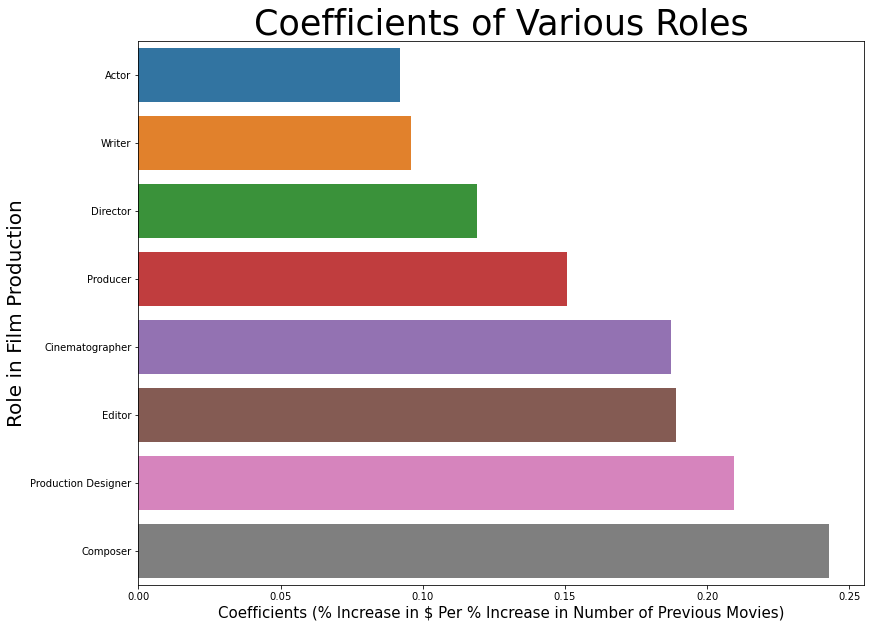

In [363]:
fig = plt.gcf()
fig.set_size_inches(13, 10)
sns.barplot(y=ridge_betas.index,x=ridge_betas[1])
plt.xlabel("Coefficients (% Increase in $ Per % Increase in Number of Previous Movies)",
           fontsize=15)
plt.ylabel('Role in Film Production',fontsize=20)
plt.title("Coefficients of Various Roles",fontsize=35)



plt.savefig('roles_importance.png')

*OLS Model, actualy done first originally

In [364]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
# Create your model
model = sm.OLS(y_train_val, X_train_val[selected_columns])

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           log_domestic   R-squared (uncentered):                   0.962
Model:                            OLS   Adj. R-squared (uncentered):              0.962
Method:                 Least Squares   F-statistic:                          1.713e+04
Date:                Fri, 17 Jul 2020   Prob (F-statistic):                        0.00
Time:                        05:34:38   Log-Likelihood:                         -13163.
No. Observations:                7541   AIC:                                  2.635e+04
Df Residuals:                    7530   BIC:                                  2.642e+04
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
log_composer                0.3001      0.032      9.472      0.000       0.238       0.362
log_editor                  0.4136      0.048      8.626      0.000       0.320       0.508
log_production_designer     0.0672      0.047      1.429      0.153      -0.025       0.159
log_producer                0.1598      0.044      3.630      0.000       0.074       0.246
log_cinematographer         0.3313      0.044      7.572      0.000       0.246       0.417
log_actor                   0.6234      0.042     14.829      0.000       0.541       0.706
log_director               -0.1852      0.053     -3.508      0.000      -0.289      -0.082
log_writer                  0.0547      0.054      1.012      0.312      -0.051       0.161
Length                      0.0531      0.000    141.085      0.000       0.052       0.054
Drama                      -0.4536      0.034    -13.492      0.000      -0.520      -0.388
PG-13                       0.1528      0.039      3.896      0.000       0.076       0.230
==============================================================================
Omnibus:                     3622.503   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           128031.183
Skew:                          -1.653   Prob(JB):                         0.00
Kurtosis:                      22.913   Cond. No.                         413.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

*Let's look at some correlations to make sure the features and results make sense

In [279]:
X_train_val.corr()['log_domestic'].sort_values()

Documentary                      -0.217464
Drama                            -0.211414
year                             -0.174428
Biography                        -0.089247
R                                -0.086949
History                          -0.079098
Dramedy                          -0.059651
Romance                          -0.057786
War                              -0.052375
Music                            -0.048540
HistoricalDrama                  -0.045500
CrimeDrama                       -0.020778
News                             -0.016651
Short                            -0.010842
TV-14                            -0.006270
Musical                           0.004521
HorrorComedy                      0.010628
Sport                             0.012473
G                                 0.017935
RomCom                            0.022045
Western                           0.025518
Length                            0.039617
Crime                             0.042699
CrimeComedy

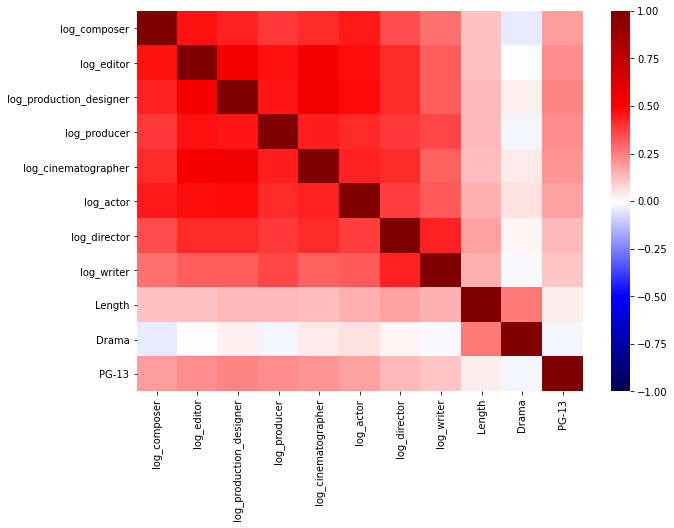

In [226]:
fig = plt.gcf()
fig.set_size_inches(10, 7)
sns.heatmap(X_train_val[selected_columns].corr(), cmap="seismic", vmin=-1, vmax=1)
plt.savefig('correlation_heatmap.png')

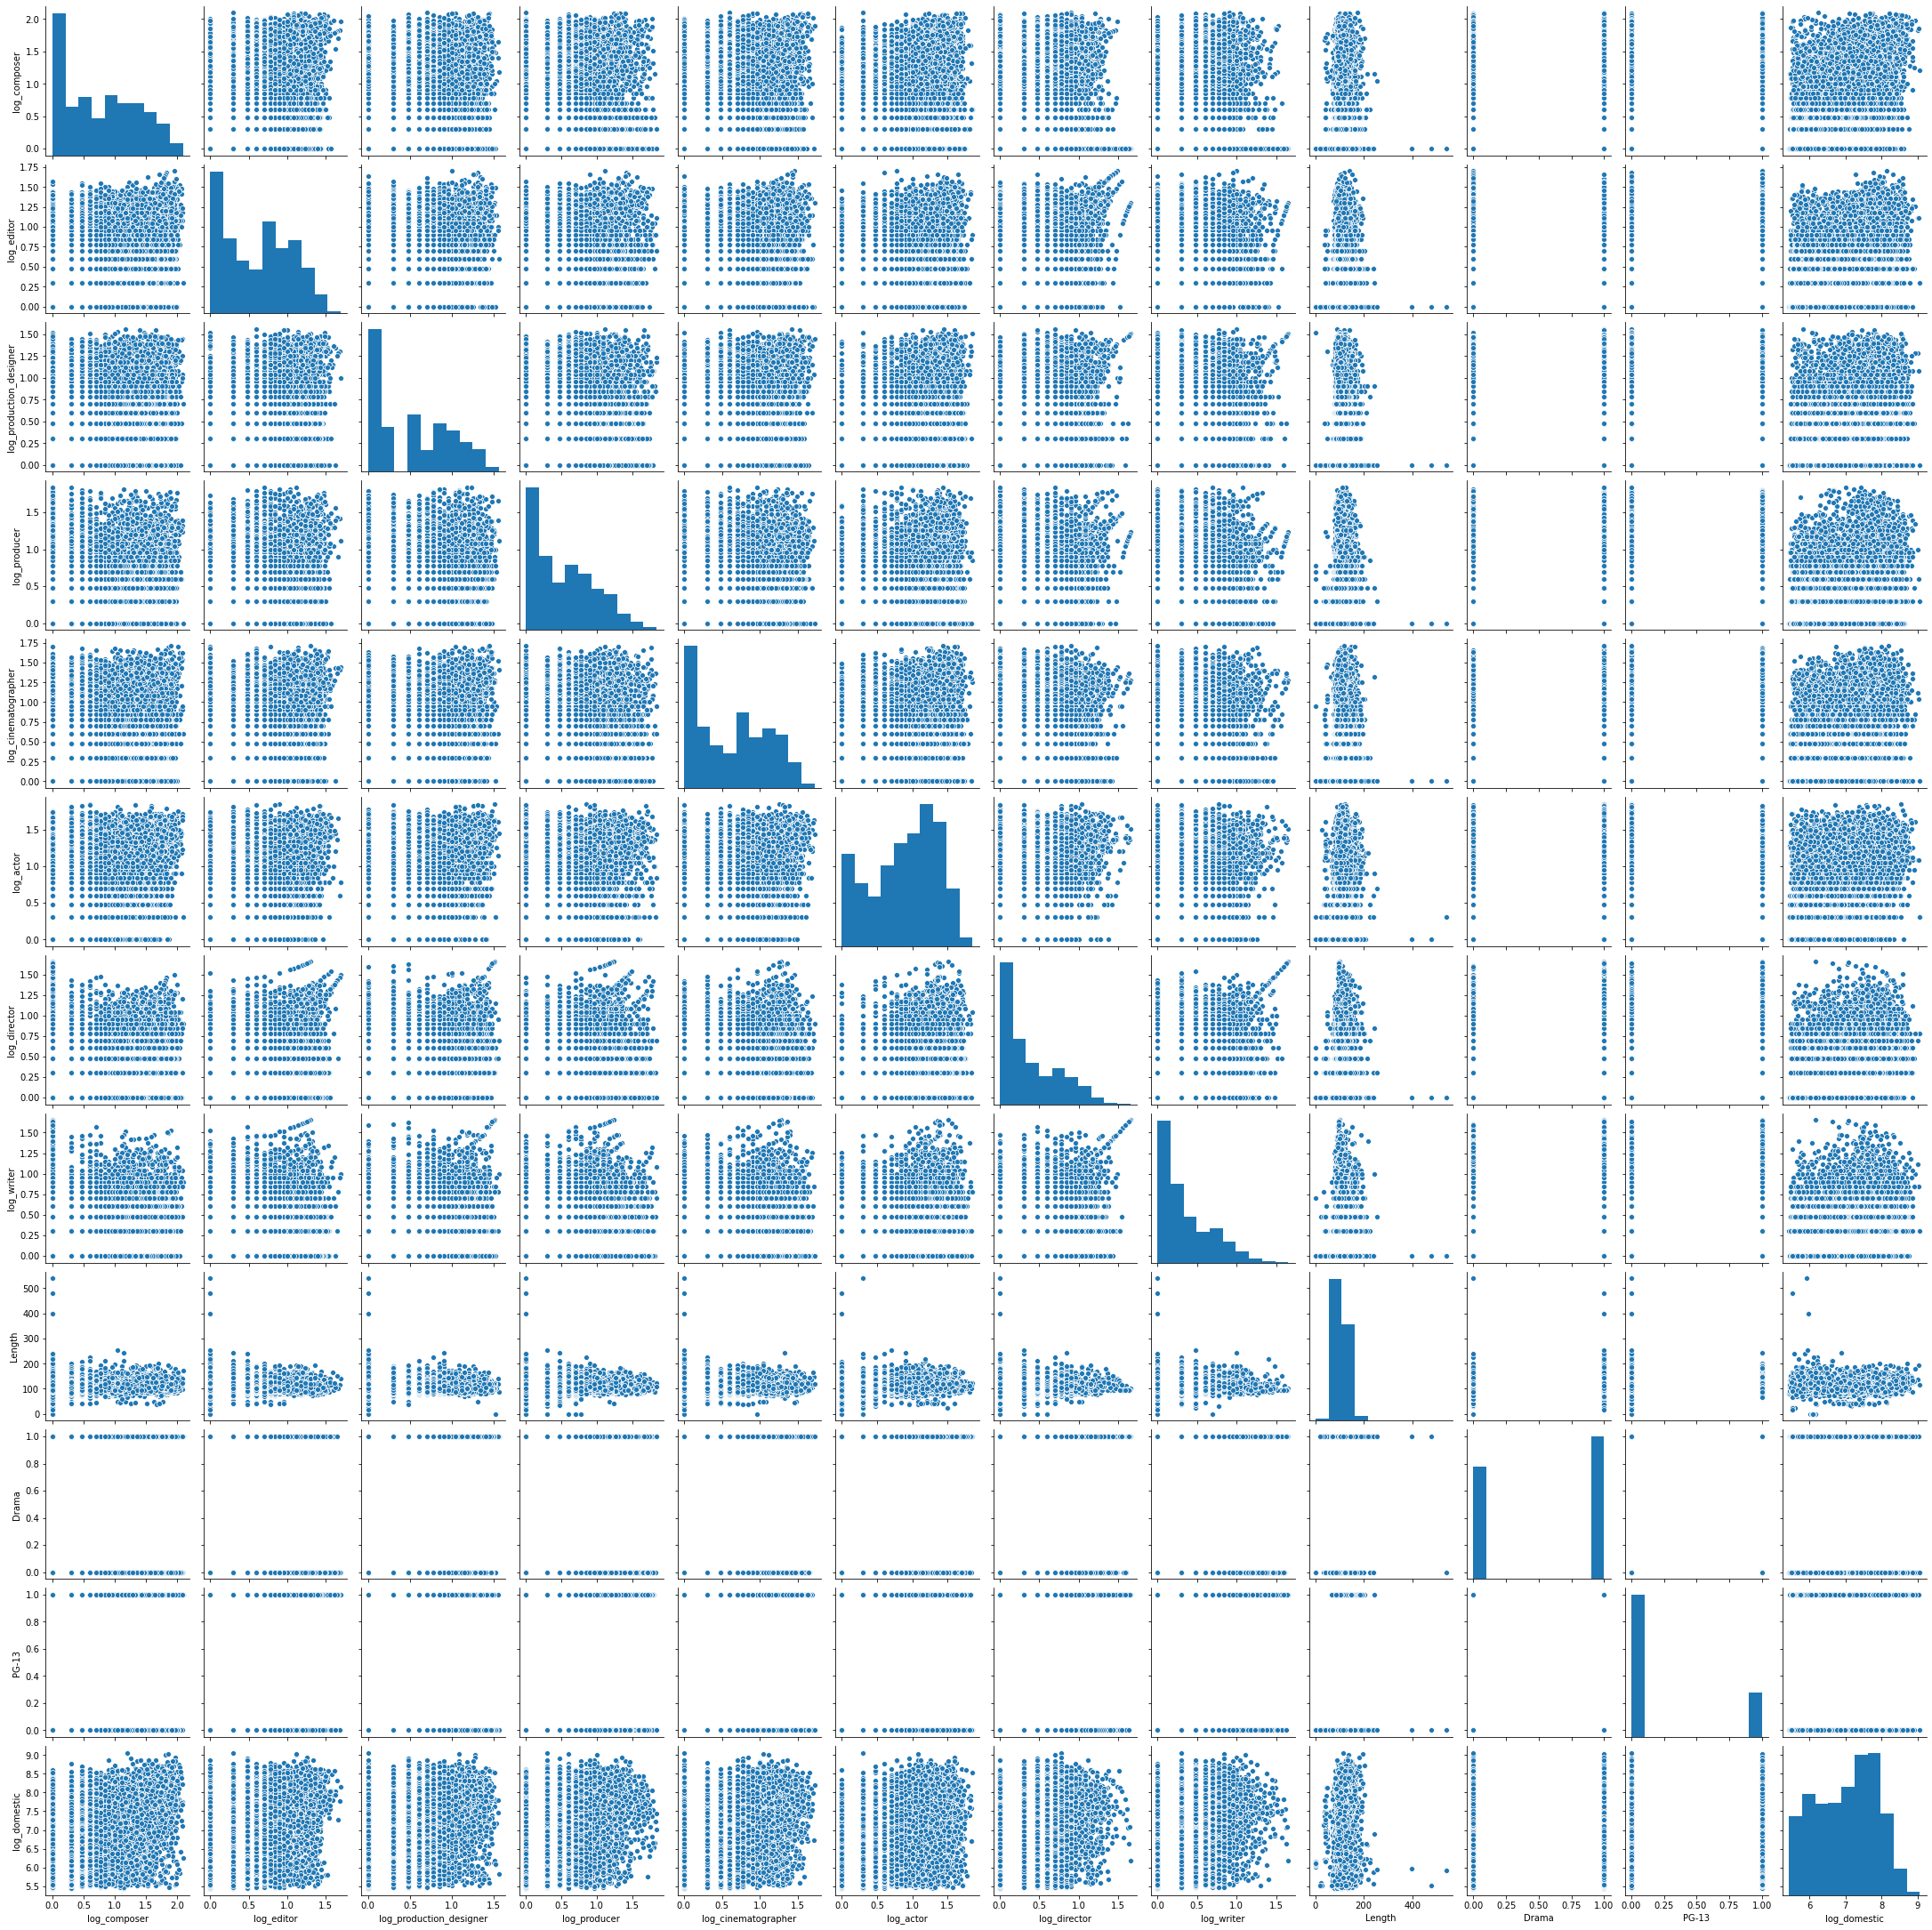

In [280]:
pairplot_columns=selected_columns+['log_domestic']
sns.pairplot(X_train_val[pairplot_columns])
plt.savefig('pair_plot.png')

**Plots of Residuals, Especially to Confirm Effectiveness of Ridge Regularization
---

Text(0.5, 1.0, 'Residuals of Ridge Model on Test Group')

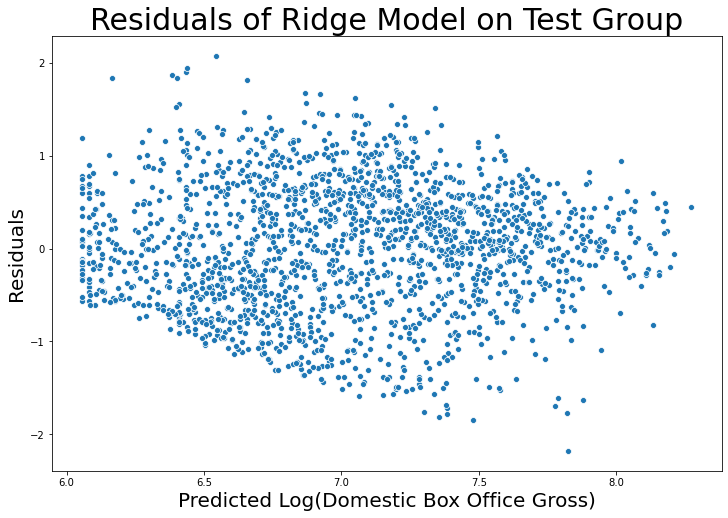

In [316]:
fig = plt.gcf()
fig.set_size_inches(12, 8)
sns.scatterplot(ridged.predict(X_test[selected_columns]),(y_test-ridged.predict(X_test[selected_columns])))


plt.xlabel("Predicted Log(Domestic Box Office Gross)",fontsize=20)
plt.ylabel('Residuals',fontsize=20)
plt.title("Residuals of Ridge Model on Test Group",fontsize=30)
#plt.legend(loc='lower right')

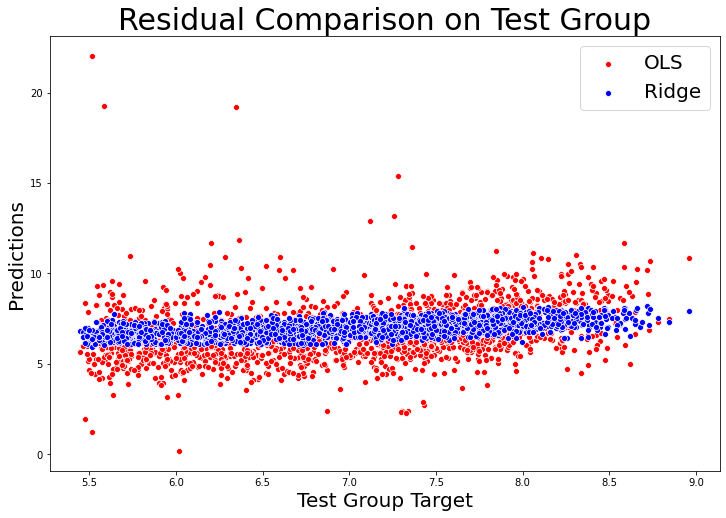

In [373]:
fig = plt.gcf()
fig.set_size_inches(12, 8)
sns.scatterplot(y_test,fit.predict(X_test[selected_columns]),
                color='red',label='OLS')
sns.scatterplot(y_test,ridged.predict(X_test[selected_columns]),
                color='blue',label='Ridge')

plt.xlabel("Test Group Target",fontsize=20)
plt.ylabel('Predictions',fontsize=20)
plt.title("Residual Comparison on Test Group",fontsize=30)
plt.legend(loc='upper right',fontsize=20)

In [228]:
np.mean(np.abs(y_test-ridge.predict(X_test[selected_columns])))

0.546198142251852

In [229]:
np.mean(np.abs(y_test-fit.predict(X_test[selected_columns])))

1.043524707483586

In [230]:
10**np.mean(np.abs(y_test-ridge.predict(X_test[selected_columns])))

3.5172087284612266

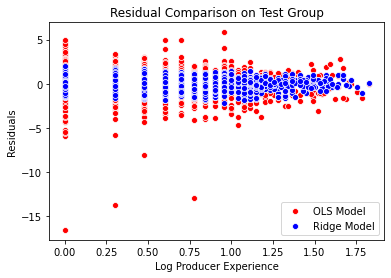

In [245]:
sns.scatterplot(X_test[selected_columns]['log_producer'],
                y_test-fit.predict(X_test[selected_columns]),
                color='red',
                label='OLS Model')
sns.scatterplot(X_test[selected_columns]['log_producer'],
                y_test-ridge.predict(X_test[selected_columns]),
                color='blue',
                label='Ridge Model');

plt.xlabel("Log Producer Experience")
plt.ylabel('Residuals')
plt.title("Residual Comparison on Test Group")
plt.legend(loc='lower right')


plt.savefig('producer_residuals.png')

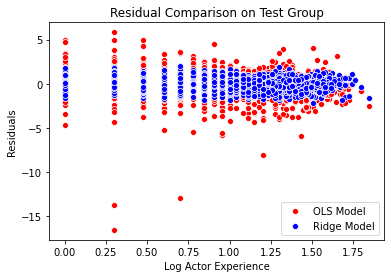

In [246]:
sns.scatterplot(X_test[selected_columns]['log_actor'],
                y_test-fit.predict(X_test[selected_columns]),
                color='red',
                label='OLS Model')
sns.scatterplot(X_test[selected_columns]['log_actor'],
                y_test-ridge.predict(X_test[selected_columns]),
                color='blue',
                label='Ridge Model');

plt.xlabel("Log Actor Experience")
plt.ylabel('Residuals')
plt.title("Residual Comparison on Test Group")
plt.legend(loc='lower right')


plt.savefig('actor_residuals.png')

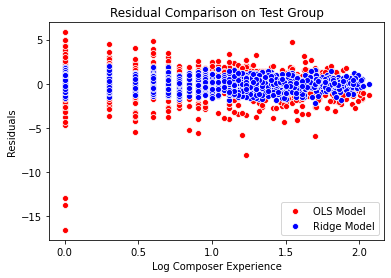

In [247]:
sns.scatterplot(X_test[selected_columns]['log_composer'],
                y_test-fit.predict(X_test[selected_columns]),
                color='red',
                label='OLS Model')
sns.scatterplot(X_test[selected_columns]['log_composer'],
                y_test-ridge.predict(X_test[selected_columns]),
                color='blue',
                label='Ridge Model');

plt.xlabel("Log Composer Experience")
plt.ylabel('Residuals')
plt.title("Residual Comparison on Test Group")
plt.legend(loc='lower right')


plt.savefig('composer_residuals.png')

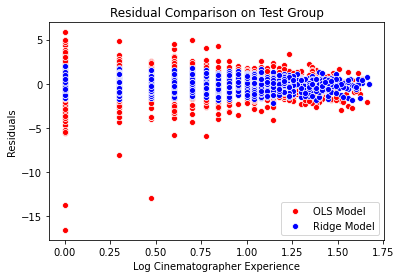

In [248]:
sns.scatterplot(X_test[selected_columns]['log_cinematographer'],
                y_test-fit.predict(X_test[selected_columns]),
                color='red',
                label='OLS Model')
sns.scatterplot(X_test[selected_columns]['log_cinematographer'],
                y_test-ridge.predict(X_test[selected_columns]),
                color='blue',
                label='Ridge Model');

plt.xlabel("Log Cinematographer Experience")
plt.ylabel('Residuals')
plt.title("Residual Comparison on Test Group")
plt.legend(loc='lower right')


plt.savefig('cinematographer_residuals.png')

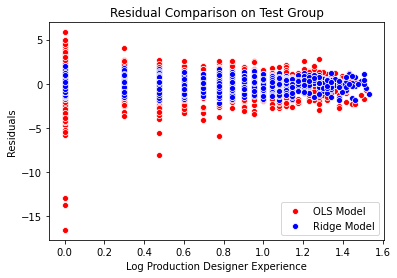

In [249]:
sns.scatterplot(X_test[selected_columns]['log_production_designer'],
                y_test-fit.predict(X_test[selected_columns]),
                color='red',
                label='OLS Model')
sns.scatterplot(X_test[selected_columns]['log_production_designer'],
                y_test-ridge.predict(X_test[selected_columns]),
                color='blue',
                label='Ridge Model');

plt.xlabel("Log Production Designer Experience")
plt.ylabel('Residuals')
plt.title("Residual Comparison on Test Group")
plt.legend(loc='lower right')


plt.savefig('production_designer_residuals.png')

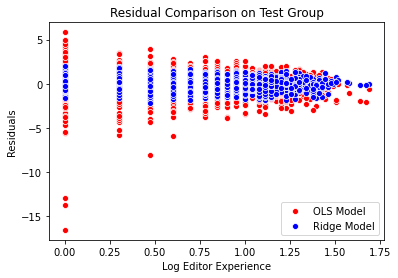

In [250]:
sns.scatterplot(X_test[selected_columns]['log_editor'],
                y_test-fit.predict(X_test[selected_columns]),
                color='red',
                label='OLS Model')
sns.scatterplot(X_test[selected_columns]['log_editor'],
                y_test-ridge.predict(X_test[selected_columns]),
                color='blue',
                label='Ridge Model');

plt.xlabel("Log Editor Experience")
plt.ylabel('Residuals')
plt.title("Residual Comparison on Test Group")
plt.legend(loc='lower right')


plt.savefig('editor_residuals.png')

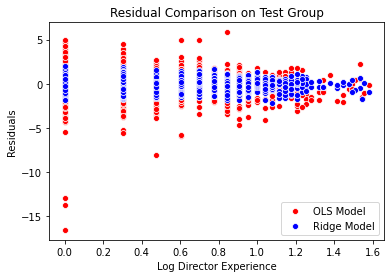

In [251]:
sns.scatterplot(X_test[selected_columns]['log_director'],
                y_test-fit.predict(X_test[selected_columns]),
                color='red',
                label='OLS Model')
sns.scatterplot(X_test[selected_columns]['log_director'],
                y_test-ridge.predict(X_test[selected_columns]),
                color='blue',
                label='Ridge Model');

plt.xlabel("Log Director Experience")
plt.ylabel('Residuals')
plt.title("Residual Comparison on Test Group")
plt.legend(loc='lower right')


plt.savefig('director_residuals.png')

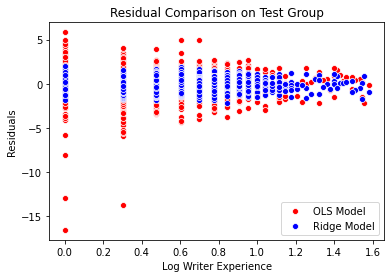

In [252]:
sns.scatterplot(X_test[selected_columns]['log_writer'],
                y_test-fit.predict(X_test[selected_columns]),
                color='red',
                label='OLS Model')
sns.scatterplot(X_test[selected_columns]['log_writer'],
                y_test-ridge.predict(X_test[selected_columns]),
                color='blue',
                label='Ridge Model');

plt.xlabel("Log Writer Experience")
plt.ylabel('Residuals')
plt.title("Residual Comparison on Test Group")
plt.legend(loc='lower right')


plt.savefig('writer_residuals.png')

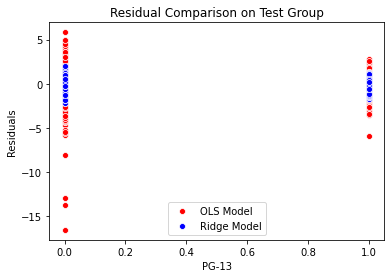

In [254]:
sns.scatterplot(X_test[selected_columns]['PG-13'],
                y_test-fit.predict(X_test[selected_columns]),
                color='red',
                label='OLS Model')
sns.scatterplot(X_test[selected_columns]['PG-13'],
                y_test-ridge.predict(X_test[selected_columns]),
                color='blue',
                label='Ridge Model');

plt.xlabel("PG-13")
plt.ylabel('Residuals')
plt.title("Residual Comparison on Test Group")
plt.legend(loc='lower center')

plt.savefig('PG-13_residuals.png')

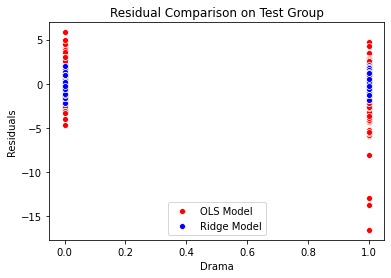

In [255]:
sns.scatterplot(X_test[selected_columns]['Drama'],
                y_test-fit.predict(X_test[selected_columns]),
                color='red',
                label='OLS Model')
sns.scatterplot(X_test[selected_columns]['Drama'],
                y_test-ridge.predict(X_test[selected_columns]),
                color='blue',
                label='Ridge Model');

plt.xlabel("Drama")
plt.ylabel('Residuals')
plt.title("Residual Comparison on Test Group")
plt.legend(loc='lower center')


plt.savefig('Drama_residuals.png')

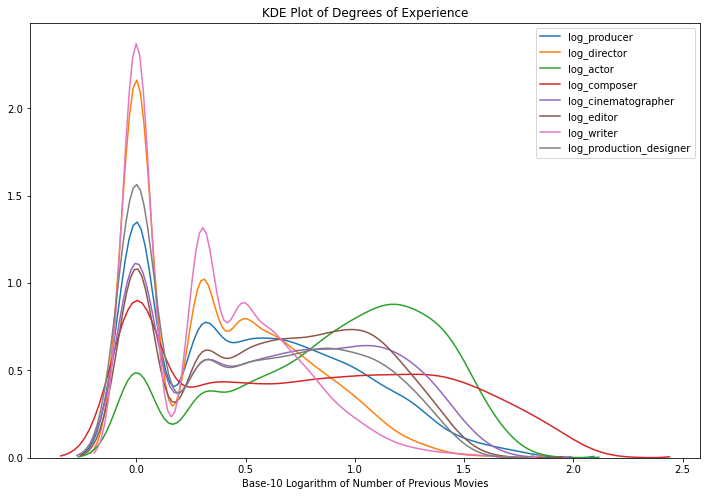

In [242]:
fig = plt.gcf()
fig.set_size_inches(12, 8)
sns.kdeplot(X_train['log_producer'])
sns.kdeplot(X_train['log_director'])
sns.kdeplot(X_train['log_actor'])
sns.kdeplot(X_train['log_composer'])
sns.kdeplot(X_train['log_cinematographer'])
sns.kdeplot(X_train['log_editor'])
sns.kdeplot(X_train['log_writer'])
sns.kdeplot(X_train['log_production_designer'])
plt.xlabel("Base-10 Logarithm of Number of Previous Movies")
plt.title("KDE Plot of Degrees of Experience") 
#fig.ax.set(xlabel='Base-e Logarithm of Number of Previous Movies', title='KDE Plot of Degrees of Experience')

plt.savefig('KDE_experience.png')

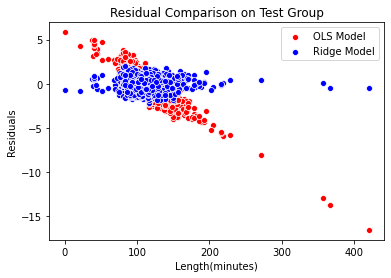

In [256]:
sns.scatterplot(X_test[selected_columns]['Length'],
                y_test-fit.predict(X_test[selected_columns]),
                color='red',
                label='OLS Model')
sns.scatterplot(X_test[selected_columns]['Length'],
                y_test-ridge.predict(X_test[selected_columns]),
                color='blue',
                label='Ridge Model');

plt.xlabel("Length(minutes)")
plt.ylabel('Residuals')
plt.title("Residual Comparison on Test Group")
plt.legend(loc='upper right')


plt.savefig('Length_residuals.png')

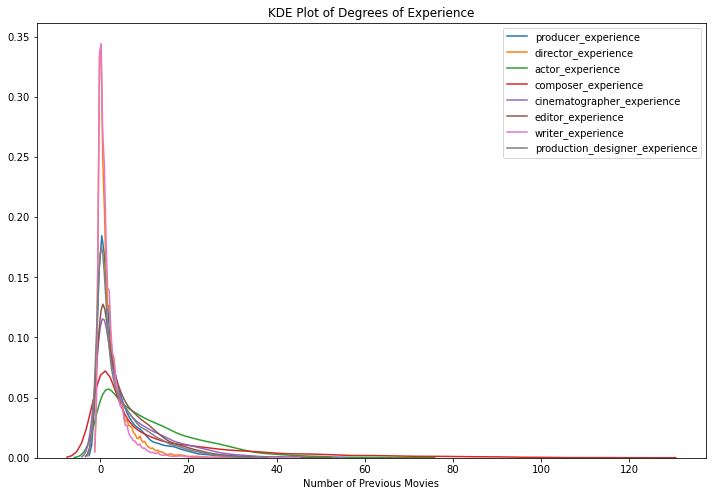

In [265]:
fig = plt.gcf()
fig.set_size_inches(12, 8)
sns.kdeplot(X_train['producer_experience'])
sns.kdeplot(X_train['director_experience'])
sns.kdeplot(X_train['actor_experience'])
sns.kdeplot(X_train['composer_experience'])
sns.kdeplot(X_train['cinematographer_experience'])
sns.kdeplot(X_train['editor_experience'])
sns.kdeplot(X_train['writer_experience'])
sns.kdeplot(X_train['production_designer_experience'])
plt.xlabel("Number of Previous Movies")
plt.title("KDE Plot of Degrees of Experience") 
#fig.ax.set(xlabel='Base-e Logarithm of Number of Previous Movies', title='KDE Plot of Degrees of Experience')

plt.savefig('KDE_experience.png')